 ## $\underline{ \textbf{Data assimilation on a PAPA}}$
 
 
 
 **Statut** : In progress
 
**Purpose**: We propose here an assimilation problem coupled with Solver DL (deep learning), the goal is to infer the mass **m** and the moment of inertia **$I_\alpha$** of a PAPA from observations made on the displacements.
 
 
 **Reference** : 
 
 [1] : [ V. Mons, J.-C. Chassaing, T. Gomez, P. Sagaut, "Reconstruction of unsteady viscous flows using data assimilation schemes", JCP 316 (2016) p. 255-280.](https://dropsu.sorbonne-universite.fr/s/oP8s9CeNS5zW5DG)
 
 [2] : [ A. Chaarane, "Data Assimilation for Flow Induced Vibrations",Stage, InstitutJean Le Rond D’Alembert, 2021.](https://dropsu.sorbonne-universite.fr/s/kr97PiKoJ8jFHfw)
 
 
-----------------------------------
**A. Chaarane**, Institute  D'Alembert, (3 May 2022)

-----------------------------------

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [16]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
import os
import sys
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import copy
from tabulate import tabulate

# ------ Importation Local
# utils for Post-Trait ( plot, ..)
sys.path.append("../../")
from Post_Trait import POSTRAIT

#--- DATA : output of DA code

# DATA : Config 1
DA_prfx   = "Mass_Ialpha_SigML/"
PATH      = "PAPA_FNN/" + DA_prfx
PATH_DATA = "../../../DATA/DA_4DEnVar_V2/"+PATH
PATH_CONF = "../../../Inference_Problem/PAPA/" 
sys.path.append(PATH_CONF)



PST = POSTRAIT(PATH_DATA)
PST.label ="DA(2)/ML"

## Other Config
# DATA : Config 2
PATH2      = "PAPA/" + DA_prfx
PATH_DATA2 = "../../../DATA/DA_4DEnVar_V2/"+PATH2
PST2 = POSTRAIT(PATH_DATA2)
PST2.label = "DA(2)"


In [17]:
PST.show_cfg()

-------------------------------------------------------------------------------------------------------------------
                                                Parametres                                         
--------------------------------------------------------------------------------------------------------------------
     Modele name      :                   PAPA                
     DA Method        :                   4DEnVar (V2)        
     Uncertains param :                                                       
                  name     : mass   I_alpha
                 reference : mass = 87.07   I_alpha = 3.73   
                 estimate  : mass = 75.0   I_alpha = 1.8   
                                                                         
     Nbr Iteration =  20  |  Nbr Ensemble =   30  | Param_sigma = 0.300000
                                                                         
     Observations     :                                                  

### Control Vectors  

In [18]:
df_param = pd.DataFrame([PST.CFG.Param_Ref, PST.CFG.Param_Est, PST.Param_Opti,PST2.Param_Opti],

                        index=["Reference", "Initialisation" ,"Optimized ("+PST.label+")", "Optimized ("+PST2.label+")"],
                        columns=PST.CFG.Param_Name,
                        )
print(tabulate(df_param.T, tablefmt='grid',headers='keys'))
print("")


+---------+-------------+------------------+------------------------+---------------------+
|         |   Reference |   Initialisation |   Optimized (DA(2)/ML) |   Optimized (DA(2)) |
+=========+=============+==================+========================+=====================+
| mass    |       87.07 |             75   |                  87.07 |               87.07 |
+---------+-------------+------------------+------------------------+---------------------+
| I_alpha |        3.73 |              1.8 |                   3.73 |                3.73 |
+---------+-------------+------------------+------------------------+---------------------+



### Function Cost


$\newcommand{\Gama}{\boldsymbol{\gamma}} 
\newcommand{\B}{\boldsymbol{B}} 
\newcommand{\C}{\boldsymbol{C}} 
\newcommand{\Gamae}{\boldsymbol{\gamma}^{(e)}}
\newcommand{\YN}{( \boldsymbol{y}{_k})_{0\leq k\leq N}}
\newcommand{\XN}{( \boldsymbol{x}{_k})_{0\leq k\leq N}}
\newcommand{\Ep}{ \boldsymbol{E}'}
\newcommand{\Beta}{ \boldsymbol{\beta}}
\newcommand{\h}{ \boldsymbol{h}}
\newcommand{\x}{ \boldsymbol{x}}
\newcommand{\y}{ \boldsymbol{y}}$



\begin{align}
J(\Gama) &= \; \frac{1}{2} \Vert \h\big(\x (\Gama)\big) - \y \Vert^2_{\C^{-1}} 
%\textbf{Grad}_{obs} &=\sum_{n=0}^{N} \boldsymbol{H}_k '^T \C^{-1}\boldsymbol{d}\\
%\textbf{Hess}_{obs}&=\sum_{n=0}^{N} \boldsymbol{H}_k '^T \C^{-1}\boldsymbol{H}_k '
\end{align}



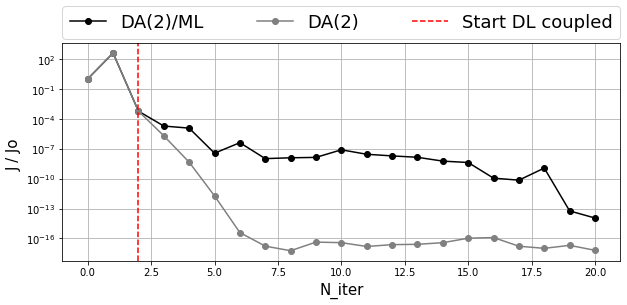

In [19]:
plt.figure(figsize=(10,4))
PST.plot_Jcost(label = PST.label)
PST2.plot_Jcost(c="grey",label = PST2.label)
plt.axvline(x=PST.i_start_ML,label="Start DL coupled",c="r",linestyle='--')
plt.grid(True)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                            mode="expand", borderaxespad=0, ncol=4,fontsize=18)
plt.show()

In [20]:
def order_magnitude(x):
    exp = math.floor(math.log(x, 10))
    return exp



def get_all_order(cost) :
    list_order = []
    min_ordr = 100000
    for er in cost :
        ordr =  order_magnitude(er)
            
        if ordr not in list_order and ordr<=0  and ordr < min_ordr : 
            list_order.append(ordr)
            min_ordr =  ordr
            
    return list_order

def get_Itr(list_order,cost) :
    list_iter = []
    for ordr in list_order :
        for i,er in enumerate(cost) :
            if order_magnitude(er) <= ordr :
                list_iter.append(i)
                break
    return list_iter

def get_Number_HF(list_iter,PST) :
    df_samples = copy.copy(PST.get_samples_df())
    
    list_Nbr_HF =[]
    for n in list_iter :
        df_trunc = df_samples.loc[(df_samples["DA_Iter"]<=n) & (df_samples["Solver"]==PST.CFG.Solver_Name)]
        list_Nbr_HF.append(len(df_trunc["Solver"].values))
    return list_Nbr_HF

All_ordr     = get_all_order(PST.J_cost/PST.J_cost[0])

list_iter   = get_Itr(All_ordr,PST.J_cost/PST.J_cost[0])
list_Nbr_HF = get_Number_HF(list_iter,PST)

list_iter_2   = get_Itr(All_ordr,PST2.J_cost/PST2.J_cost[0])
list_Nbr_HF_2 = get_Number_HF(list_iter_2,PST2)
list_iter

df_compare = pd.DataFrame([All_ordr,list_Nbr_HF_2,list_Nbr_HF],
                    index = ["Log(J/Jo)",PST2.label + " : HF",PST.label+" : HF"])
print(tabulate(df_compare.T, tablefmt='grid',headers='keys', showindex = False))
print("")

+-------------+--------------+-----------------+
|   Log(J/Jo) |   DA(2) : HF |   DA(2)/ML : HF |
+=============+==============+=================+
|           0 |           30 |              30 |
+-------------+--------------+-----------------+
|          -4 |           90 |              89 |
+-------------+--------------+-----------------+
|          -5 |          120 |             117 |
+-------------+--------------+-----------------+
|          -8 |          150 |             171 |
+-------------+--------------+-----------------+
|          -9 |          150 |             413 |
+-------------+--------------+-----------------+
|         -10 |          180 |             467 |
+-------------+--------------+-----------------+
|         -11 |          180 |             497 |
+-------------+--------------+-----------------+
|         -14 |          210 |             549 |
+-------------+--------------+-----------------+



##  Relative Error  

$$ e_r = \frac{\gamma_{opti} - \gamma_{ref} } {\gamma_{ref}} \times 100$$

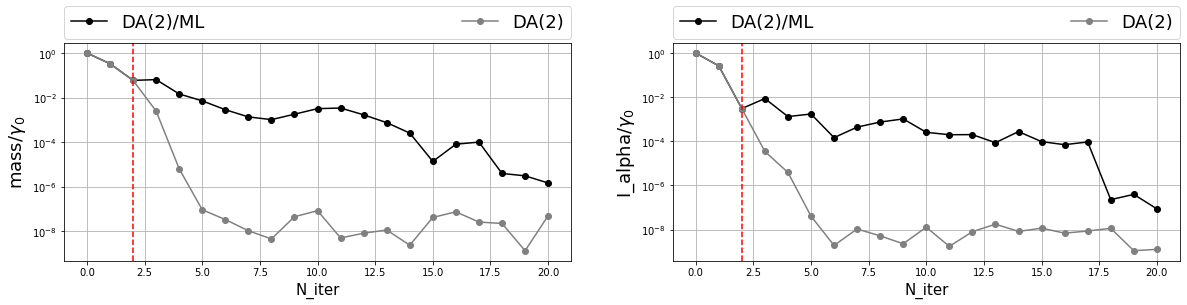

In [6]:
n_col = 2
plt.figure(figsize=(20,4))

N_iter  = [j for j in range(len(PST.Param_error))]
N_iter2 = [k for k in range(len(PST2.Param_error))]
k=1
for i,name in enumerate(PST.CFG.Param_Name) :
    
    plt.subplot(1,n_col,k)
    plt.plot(N_iter, PST.Param_error[:,i]/PST.Param_error[0,i],'-o', c="k",label = PST.label)
    plt.plot(N_iter2, PST2.Param_error[:,i]/PST2.Param_error[0,i],'-o', c="grey",label = PST2.label)
    plt.xlabel('N_iter',fontsize=15)
    plt.ylabel(name+r"$ / \gamma_0$",fontsize=18)
    plt.yscale("log")
    plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                            mode="expand", borderaxespad=0, ncol=4,fontsize=18)    
    plt.grid()
    plt.axvline(x=PST.i_start_ML,label="Start DL coupled",c="r",linestyle='--')
    
    if k ==n_col and i!=len(PST.CFG.Param_Name)-1:
        plt.show()
        plt.figure(figsize=(20,4))
        k=1
    else :
        k+=1


### ML and HF Solver of Propagation

In [7]:
df_samples = copy.copy(PST.get_samples_df())
df_samples["Status"] =""


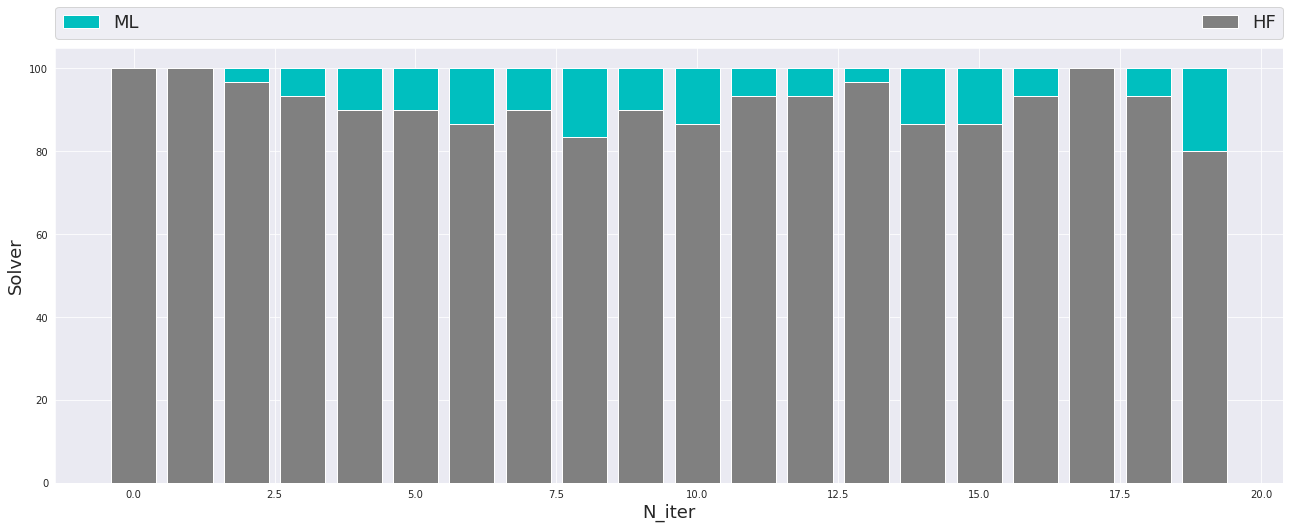

In [8]:
n_iter = len(PST.J_cost) -1
N_ML = np.zeros(n_iter)
N_HF = np.zeros(n_iter)
for i in range(n_iter):
    N_HF[i] = df_samples.loc[(df_samples["DA_Iter"] == i ) & (df_samples["Solver"] == PST.CFG.Solver_Name )].count()["Solver"]
    N_ML[i] = df_samples.loc[(df_samples["DA_Iter"] == i ) & (df_samples["Solver"] == PST.CFG.DL_Model )].count()["Solver"]
N_iter = np.arange(n_iter)
P_tot = np.ones(n_iter)*100
P_HF  =  N_HF * 100/N_HF[0]
with sns.axes_style("darkgrid"):
    plt.figure(figsize = (22,8))
    plt.bar(N_iter,P_tot,color = "c", label = "ML")
    plt.bar(N_iter,P_HF,color = "grey", label = "HF")
    plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                            mode="expand", borderaxespad=0, ncol=4,fontsize=18)
    plt.xlabel("N_iter",fontsize = 18)
    plt.ylabel("Solver",fontsize = 18)

In [9]:
# N_ML = np.zeros(len(PST.J_cost)-1)
# N_HF = np.zeros(len(PST.J_cost)-1)
# for i in range(len(PST.J_cost)-1) :
#     N_ML[i] = df_samples.loc[ (df_samples["DA_Iter"] ==i) &  (df_samples["Solver"] == PST.CFG.DL_Model)].count()["Solver"]
#     N_HF[i] = df_samples.loc[ (df_samples["DA_Iter"] ==i) &  (df_samples["Solver"] == PST.CFG.Solver_Name)].count()["Solver"]   

# R_HF = (N_HF[0] - N_ML) / N_HF[0]

# N_tot = np.ones(len(PST.J_cost)-1)* N_HF[0]
# N_iter = np.arange(len(PST.J_cost)-1)+1
# plt.figure(figsize=(20,8))
# plt.bar(N_iter, N_tot,color="g", label ="ML")
# plt.bar(N_iter, N_HF,color="b",label ="HF")
# plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
#                             mode="expand", borderaxespad=0, ncol=4,fontsize=18)  
# plt.xlabel('N_iter',fontsize=15)
# plt.ylabel('Sample',fontsize=15)
# plt.show()

In [10]:
# with sns.axes_style("darkgrid"):

#     # Draw a nested barplot by species and sex
#     g = sns.catplot(
#         data=df_samples,x="Solver",hue="Solver",col = "DA_Iter", col_wrap=10,kind="count", height=2.5, aspect=.8
#     )


### Sample analysis during the optimisation process. 

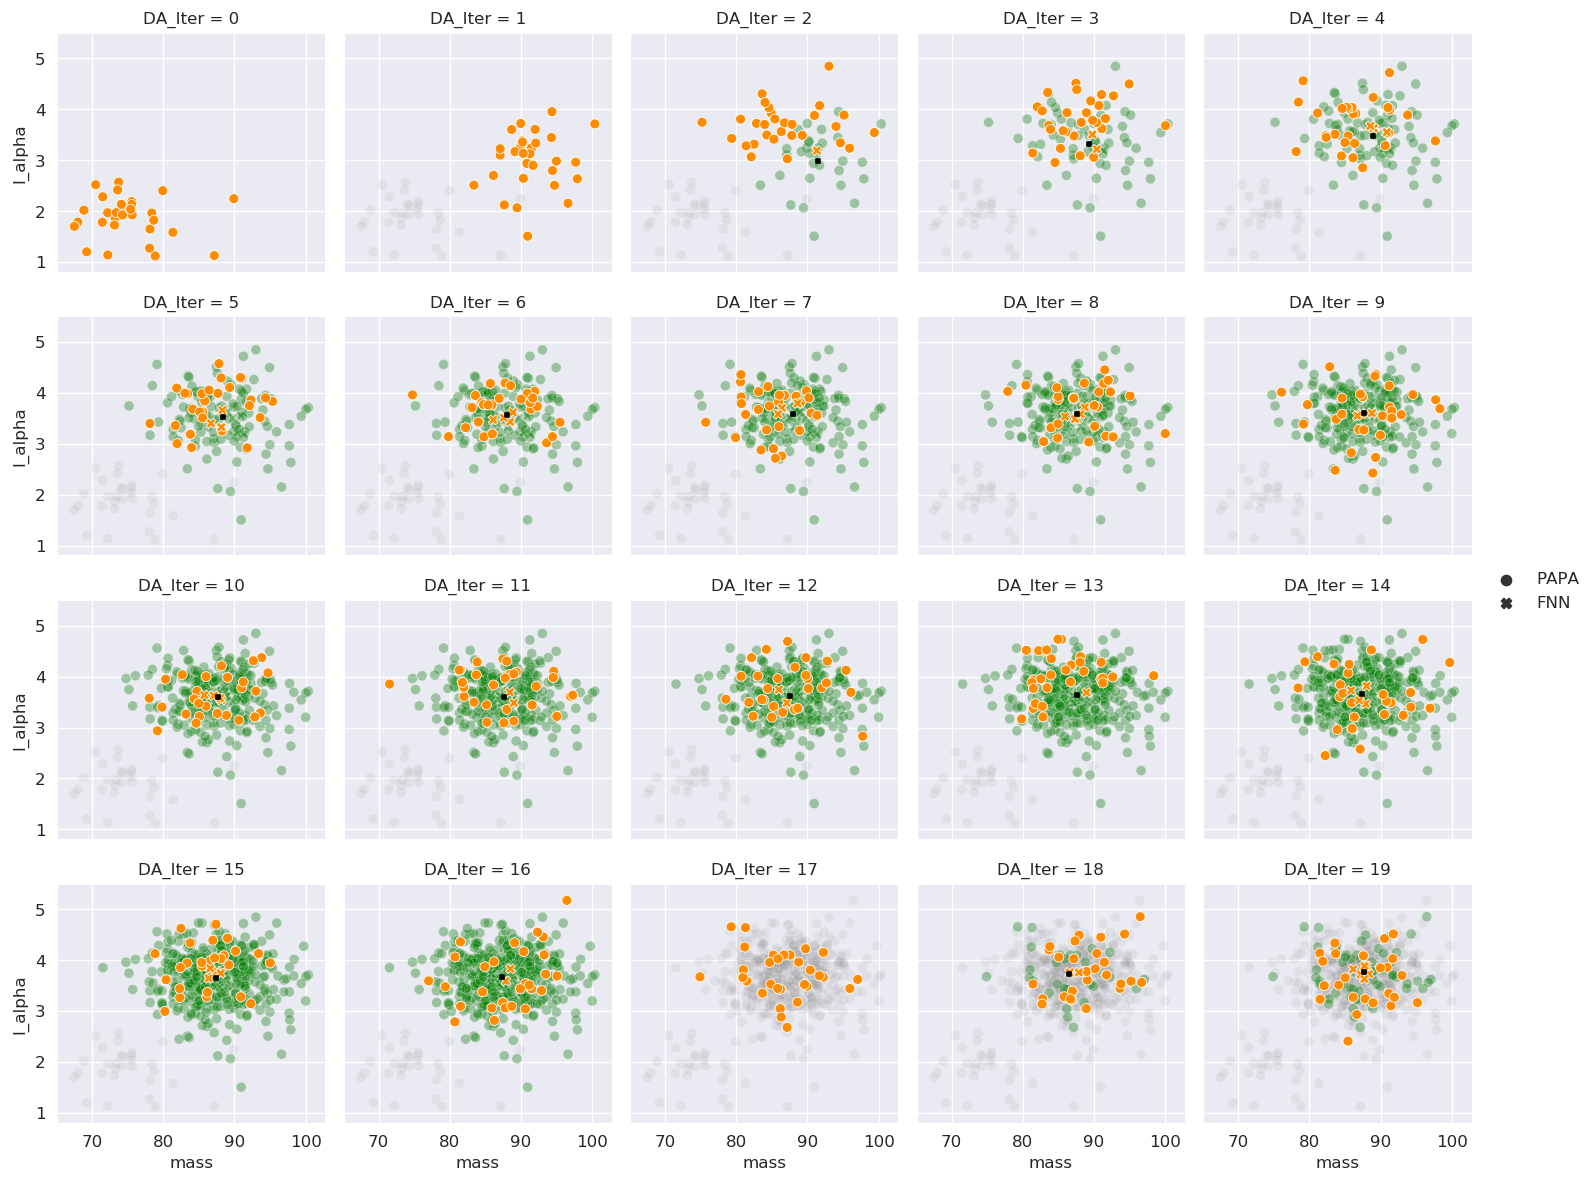

In [11]:
# df_samples[df_samples["DA_Iter"]==0]["Solver"]= /
# df_samples.loc[df_samples["DA_Iter"] == 1, "Status"] = "old"
# df_samples.loc[df_samples["DA_Iter"] == 0, "Status"] = "new"
# df_samples.loc[df_samples["DA_Iter"] == 59, "Status"] = "old"
with sns.axes_style("darkgrid"):
    g=sns.FacetGrid(df_samples, col="DA_Iter", height=2.5, col_wrap=5)
    g.map_dataframe(sns.scatterplot, x=PST.CFG.Param_Name[0], y=PST.CFG.Param_Name[1],style ="Solver",palette="coolwarm")


    
    k = 0
    i_start_train = PST.i_start_ML -1
    for ax in g.axes.flatten() :
        
        ## ---- all old samples :
        if k>0 :
            df_samples_old = df_samples.loc[ (df_samples["DA_Iter"] <k)].copy()
        else :
            df_samples_old = df_samples.loc[ (df_samples["DA_Iter"] ==k)].copy()
        sns.scatterplot(data=df_samples_old, x=PST.CFG.Param_Name[0], ax=ax,y=PST.CFG.Param_Name[1],style="Solver", alpha=0.1,color ="grey")
        

        ## ----- new samples (Current)
        df_samples_new = df_samples.loc[ (df_samples["DA_Iter"] ==k)].copy()
        
        ## update i start train 
        if PST.CFG.DL_Model not in df_samples_new["Solver"].values :
            i_start_train = k
        ## ---- Current train sample  
        if k>= PST.i_start_ML :
            df_sample_train = df_samples.loc[ (df_samples["DA_Iter"] >=i_start_train) & (df_samples["DA_Iter"] <k)].copy()   
            sns.scatterplot(data=df_sample_train, x=PST.CFG.Param_Name[0], ax=ax,y=PST.CFG.Param_Name[1],style="Solver", alpha=0.3,color="g")
        
        sns.scatterplot(data=df_samples_new, x=PST.CFG.Param_Name[0], ax=ax,y=PST.CFG.Param_Name[1],style="Solver", alpha=1.,color="darkorange")
        
        ## ----plot the prediction zone 
        if k>= PST.i_start_ML :
            # compute center 
            Samples_train = df_sample_train[PST.CFG.Param_Name].values
            if len(Samples_train)>0:
                center = np.zeros(PST.CFG.Param_Dim)
                for prm in Samples_train :
                    center+=prm
                center = (1/len(Samples_train))*center
                # rayon
                r =  PST.CFG.Rayon_Cluster

                theta = np.linspace(0, 2*np.pi, 100)
                x1 = r*np.cos(theta) + center[0]
                x2 = r*np.sin(theta) + center[1]
                
                ax.scatter([center[0]],[center[1]],marker = "s",color="k",s=5)
        
        k+=1
        ax.legend().remove() 
    # g.axes.flatten()[:].legend().remove()    
    g.fig.set_dpi(120)
    g.add_legend()
    
    # fix the legends


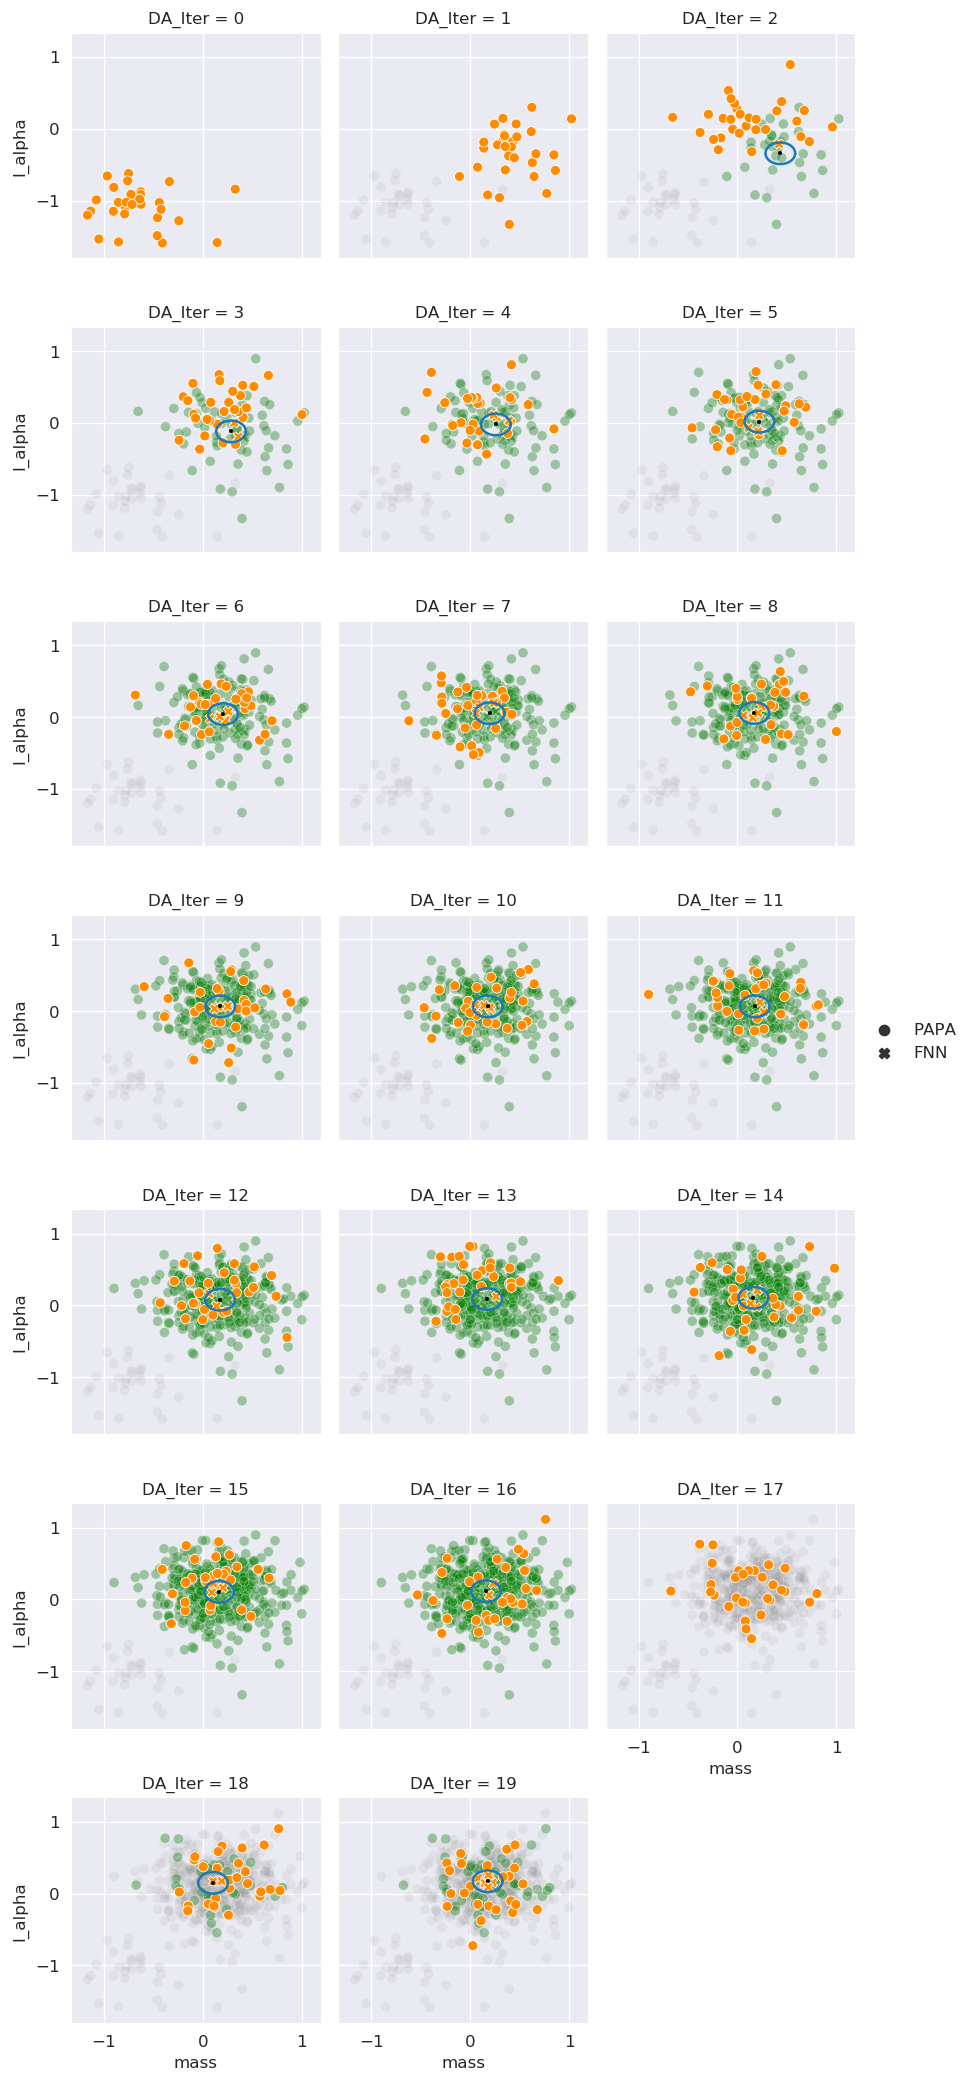

In [12]:
df_samples_bar  = copy.copy(df_samples)
for i,parm_nm in enumerate(PST.CFG.Param_Name): 
    df_samples_bar[parm_nm] =( 2*df_samples[parm_nm] - PST.CFG.Param_Bounds[i][0] -PST.CFG.Param_Bounds[i][1])\
                    / (PST.CFG.Param_Bounds[i][1]-PST.CFG.Param_Bounds[i][0])


with sns.axes_style("darkgrid"):
    g=sns.FacetGrid(df_samples_bar, col="DA_Iter", height=2.5, col_wrap=3)
    g.map_dataframe(sns.scatterplot, x=PST.CFG.Param_Name[0], y=PST.CFG.Param_Name[1],style ="Solver",palette="coolwarm")


    
    k = 0
    i_start_train = PST.i_start_ML -1
    for ax in g.axes.flatten() :
        
        ## ---- all old samples :
        if k>0 :
            df_samples_old_bar = df_samples_bar.loc[ (df_samples_bar["DA_Iter"] <k)].copy()
        else :
            df_samples_old_bar = df_samples_bar.loc[ (df_samples_bar["DA_Iter"] ==k)].copy()
        sns.scatterplot(data=df_samples_old_bar, x=PST.CFG.Param_Name[0], ax=ax,y=PST.CFG.Param_Name[1],style="Solver", alpha=0.1,color ="grey")
        

        ## ----- new samples (Current)
        df_samples_new_bar = df_samples_bar.loc[ (df_samples_bar["DA_Iter"] ==k)].copy()
        
        ## update i start train 
        if PST.CFG.DL_Model not in df_samples_new_bar["Solver"].values :
            i_start_train = k
        ## ---- Current train sample  
        if k>= PST.i_start_ML :
            df_sample_train_bar = df_samples_bar.loc[ (df_samples_bar["DA_Iter"] >=i_start_train) & (df_samples_bar["DA_Iter"] <k)].copy()   
            sns.scatterplot(data=df_sample_train_bar, x=PST.CFG.Param_Name[0], ax=ax,y=PST.CFG.Param_Name[1],style="Solver", alpha=0.3,color="g")
        
        sns.scatterplot(data=df_samples_new_bar, x=PST.CFG.Param_Name[0], ax=ax,y=PST.CFG.Param_Name[1],style="Solver", alpha=1.,color="darkorange")
        
        ## ----plot the prediction zone 
        if k>= PST.i_start_ML :
            # compute center 
            Samples_train_bar = df_sample_train_bar[PST.CFG.Param_Name].values
            if len(Samples_train_bar)>0:
                center = np.zeros(PST.CFG.Param_Dim)
                for prm in Samples_train_bar :
                    center+=prm
                center = (1/len(Samples_train_bar))*center
                # rayon
                r =  PST.CFG.Rayon_Cluster

                theta = np.linspace(0, 2*np.pi, 100)
                x1 = r*np.cos(theta) + center[0]
                x2 = r*np.sin(theta) + center[1]
                ax.plot(x1,x2)
                ax.scatter([center[0]],[center[1]],marker = "s",color="k",s=1)
        
        k+=1
        ax.legend().remove() 
    # g.axes.flatten()[:].legend().remove()    
    g.fig.set_dpi(120)
    g.add_legend()
    
    # fix the legends

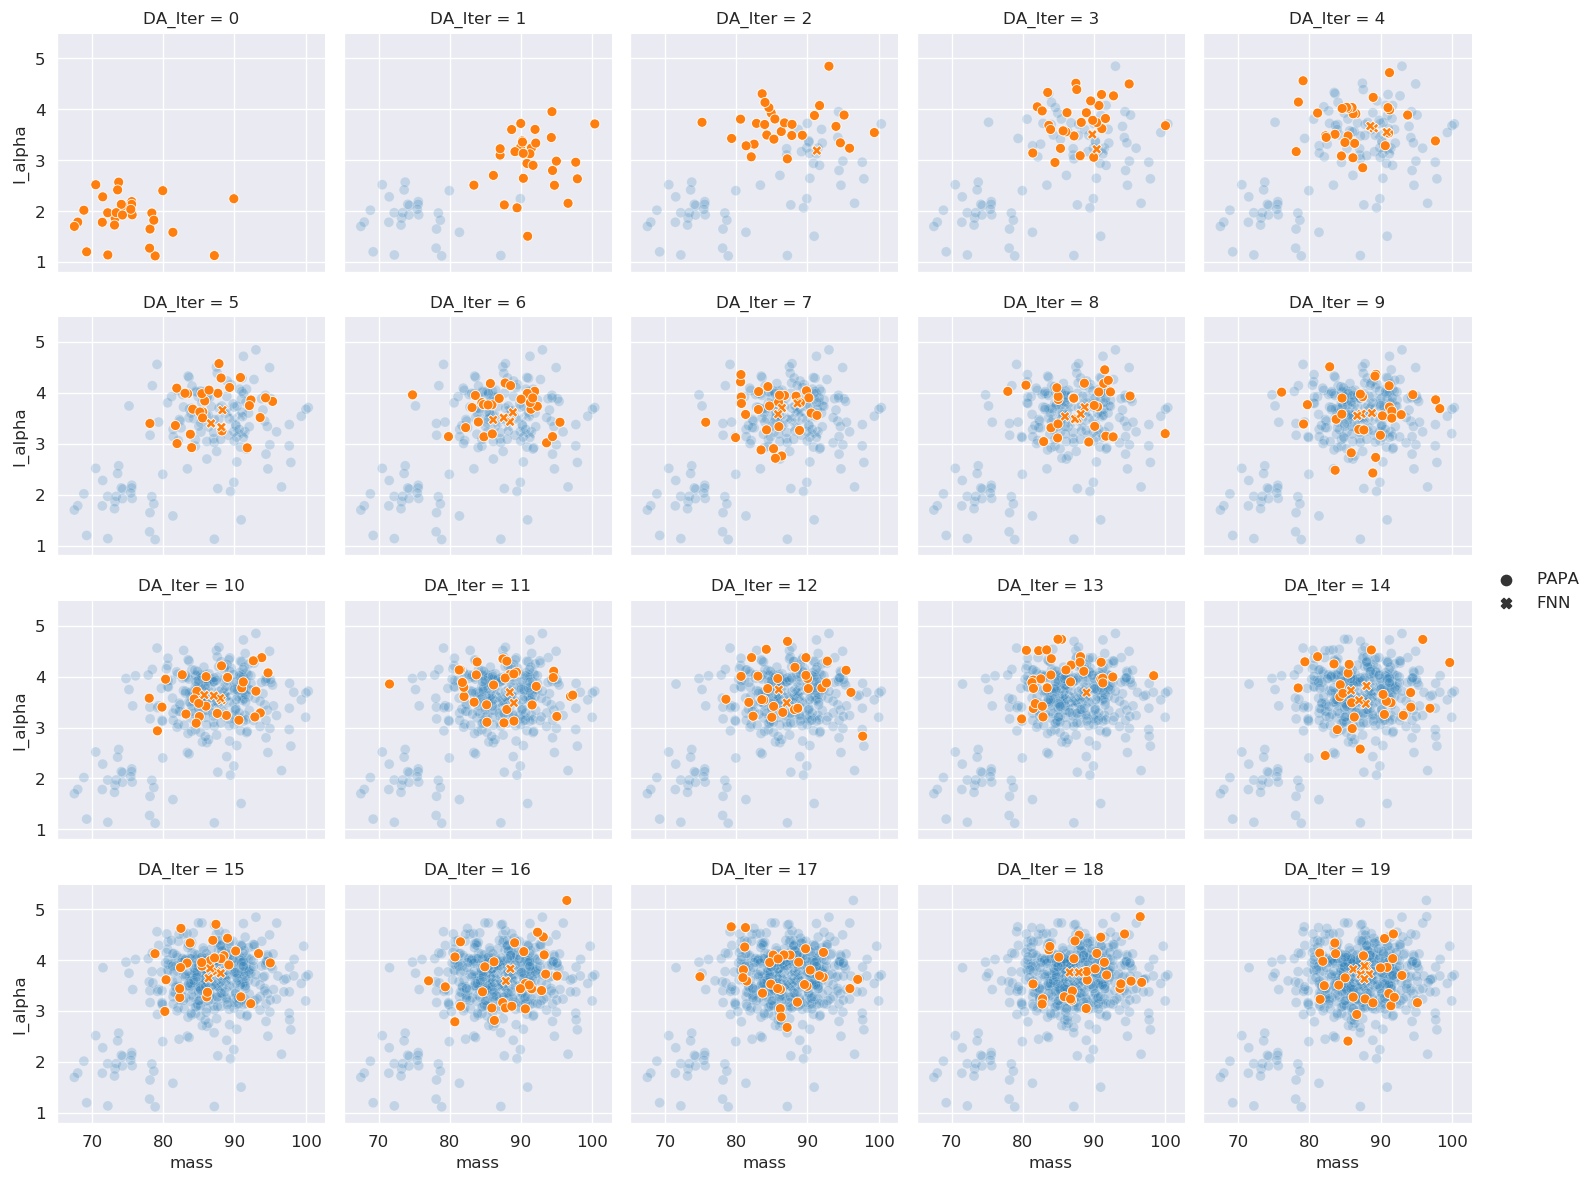

In [13]:
with sns.axes_style("darkgrid"):
    g=sns.FacetGrid(df_samples, col="DA_Iter", height=2.5, col_wrap=5)
    g.map_dataframe(sns.scatterplot, x=PST.CFG.Param_Name[0], y=PST.CFG.Param_Name[1],style ="Solver",palette="coolwarm")


    
    k = 0
    for ax in g.axes.flatten() :
        if k>0 :
            df_samples_old = df_samples.loc[ (df_samples["DA_Iter"] <k)].copy()
        else :
            df_samples_old = df_samples.loc[ (df_samples["DA_Iter"] ==k)].copy()
            
        sns.scatterplot(data=df_samples_old, x=PST.CFG.Param_Name[0], ax=ax,y=PST.CFG.Param_Name[1],style="Solver", alpha=0.2)
        df_samples_new = df_samples.loc[ (df_samples["DA_Iter"] ==k)].copy()
        sns.scatterplot(data=df_samples_new, x=PST.CFG.Param_Name[0], ax=ax,y=PST.CFG.Param_Name[1],style="Solver", alpha=1.)

        k+=1
        ax.legend().remove() 
    # g.axes.flatten()[:].legend().remove()    
    g.fig.set_dpi(120)
    g.add_legend()
    
    # fix the legends


In [14]:
# plt.figure(figsize=(30,150))
# PST.plot_obs_ref_est_opt()